In [2]:
import d_expanse.d_exp_simple as dxp
from gen_utils import k_clustering as k_means
import seaborn as sn
import pandas as pd

D-EXPANSE module initialised


In [3]:
model, country_df, tech_df = dxp.run_d_expanse()


Problem: 
- Name: unknown_copy
  Lower bound: 24794.59999752443
  Upper bound: 24794.59999752443
  Number of objectives: 1
  Number of constraints: 85116
  Number of variables: 22800
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 22800
  Number of nonzeros: 235017
  Sense: 1
  Number of solutions: 1
Solver: 
- Name: Gurobi 9.52
  Status: ok
  Wallclock time: 2.53261399269104
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [4]:
elec_demand = (
        country_df.loc["ElSupplied_annual_central"]["Value"]
        - tech_df.loc["Actual_generation", "Storage"]
        - country_df.loc["Distribution_losses"]["Value"]
    )
k_ratio_y_d, demand_y_d_h = k_means.get_demand_shape(model.Years, model.DxpDays, elec_demand)
elec_supplied_ratio_y0 = k_means.get_supplied_ratio_y_d(demand_y_d_h, k_ratio_y_d, model.DxpDays, model.Years.first())

In [5]:
imp_cap_y0 = model.imp_p_nom["Import",1990].value
exp_cap_y0 = model.exp_p_nom["Export",1990].value
line_cap_y0 = model.line_p_nom["Line",1990].value
print("Import cap:", imp_cap_y0, 
      "Export cap:", exp_cap_y0,
      "Line cap:", line_cap_y0, "in GW")

Import cap: 3.556 Export cap: 3.556 Line cap: 3.556 in GW


<AxesSubplot:>

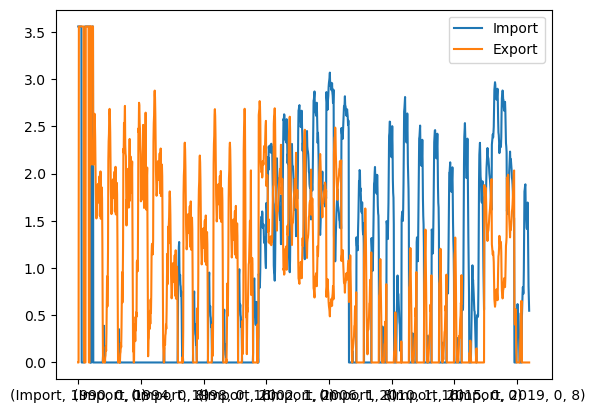

In [6]:
hourly = pd.DataFrame()
hourly["Import"] = pd.Series(model.imp_p.extract_values(), name=model.imp_p.name)
hourly["Export"] = model.exp_p.extract_values().values()
hourly.plot()


In [7]:
yearly = pd.DataFrame(columns=hourly.columns)
# hourly.droplevel(0).index.get_level_values(0)
names = hourly.index.get_level_values(0).unique()
years = model.Years
days = model.DxpDays
hours = model.DxpHours
for c in hourly.columns:
    for n in names:
        for y in years:
            yearly.loc[y,c] = sum([hourly.loc[("Import", y,d,h),c]/ 1000*(365 * k_ratio_y_d[y][d]) for d in model.DxpDays for h in model.DxpHours])

<AxesSubplot:>

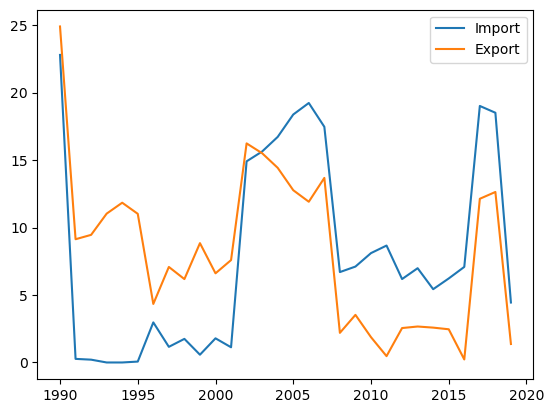

In [8]:
yearly.plot()

<AxesSubplot:>

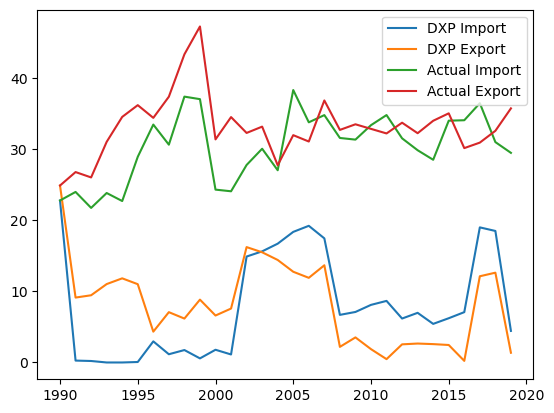

In [9]:
trade_cap = pd.DataFrame()
trade_cap["DXP Import"] = yearly["Import"]
trade_cap["DXP Export"] = yearly["Export"]
trade_cap["Actual Import"] = country_df.loc["Actual_import"]["Value"]
trade_cap["Actual Export"] = country_df.loc["Actual_export"]["Value"]
trade_cap.plot()

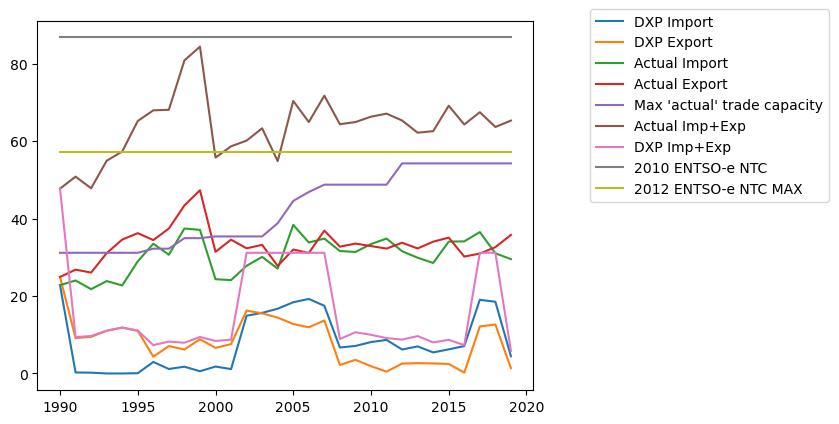

In [10]:
trade_cap["Max 'actual' trade capacity"] = tech_df.loc["Actual_capacity"]["Import"]*365*24/1000
trade_cap["Actual Imp+Exp"] = trade_cap["Actual Import"] + trade_cap["Actual Export"]
trade_cap["DXP Imp+Exp"] = trade_cap["DXP Import"] + trade_cap["DXP Export"]
trade_cap["2010 ENTSO-e Pmax"] = 9.9*365*24/1000 # 9 GW
trade_cap["2012 ENTSO-e NTC MAX"] = 6.54*365*24/1000 # 
ax = trade_cap.plot.line()
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [11]:
model.line_p_nom.pprint()

line_p_nom : Size=30, Index=line_p_nom_index
    Key            : Lower : Value : Upper : Fixed : Stale : Domain
    ('Line', 1990) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1991) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1992) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1993) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1994) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1995) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1996) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1997) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1998) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 1999) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 2000) :     0 : 3.556 :   8.0 : False : False : NonNegativeReals
    ('Line', 2001) :     0 : 

In [14]:
from pyomo.environ import *
pyomo.util.model_size.build_model_size_report(model)

ModelSizeReport(activated = Bunch(binary_variables = 0, constraints = 85116, continuous_variables = 22800, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 22800), overall = Bunch(binary_variables = 0, constraints = 85116, continuous_variables = 22800, disjunctions = 0, disjuncts = 0, integer_variables = 0, nonlinear_constraints = 0, variables = 22800), warning = Bunch(unassociated_disjuncts = 0))